<a href="https://colab.research.google.com/github/surpha/mVQA/blob/main/conquer/Image_Mapping_multilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual Joint Image & Text Embeddings

[SentenceTransformers](https://www.sbert.net) can be used to map images and texts to the same vector space.

As model, we use the [OpenAI CLIP Model](https://github.com/openai/CLIP), which was trained on a large set of images and image alt texts.

The original CLIP Model only works for English, hence, we used [Multilingual Knowlegde Distillation](https://arxiv.org/abs/2004.09813) to make this model work with 50+ languages.

As a source for photos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images.

In [1]:
# %%capture
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

# Here we load the multilingual CLIP model. Note, this model can only encode text.
# If you need embeddings for images, you must load the 'clip-ViT-B-32' model
model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.65k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

In [3]:
# Next, we get about 25k images from Unsplash
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)

    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)

    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)


  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [4]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings:
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)

    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)
    print("Images:", len(img_names))
else:
    #For embedding images, we need the non-multilingual CLIP model
    img_model = SentenceTransformer('clip-ViT-B-32')

    img_names = list(glob.glob('photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = img_model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)


  0%|          | 0.00/51.8M [00:00<?, ?B/s]

Images: 24996


In [5]:
import torch
filepath = 'photos/'+img_names[0]
one_emb = torch.tensor(img_emb[0])
img_model = SentenceTransformer('clip-ViT-B-32')
comb_emb = img_model.encode(Image.open(filepath), convert_to_tensor=True).cpu()
print(util.cos_sim(one_emb, comb_emb))

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

tensor([[0.9985]])


In [22]:
# Next, we define a search function.
def search(query, k=5):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)

    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]

    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))


Query:


'Two dogs playing in the snow'

lyStEjlKNSw.jpg


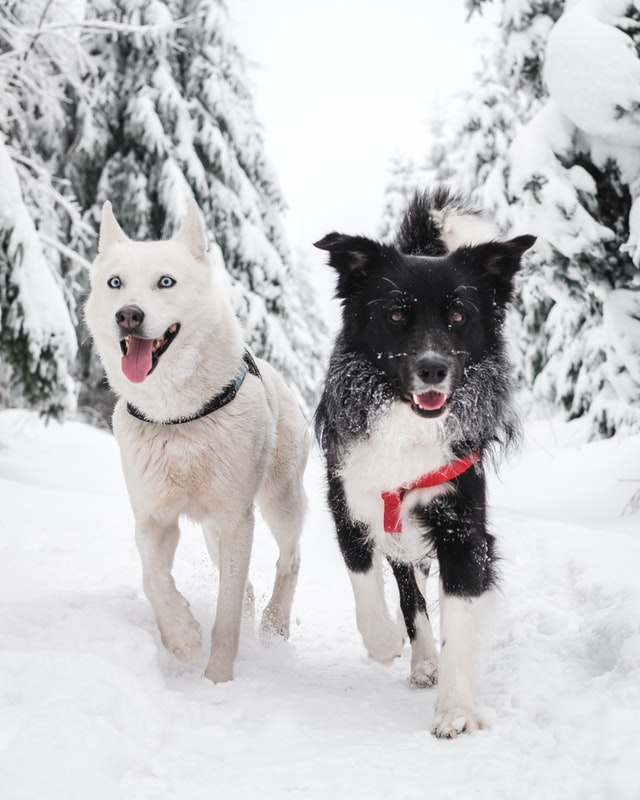

FAcSe7SjDUU.jpg


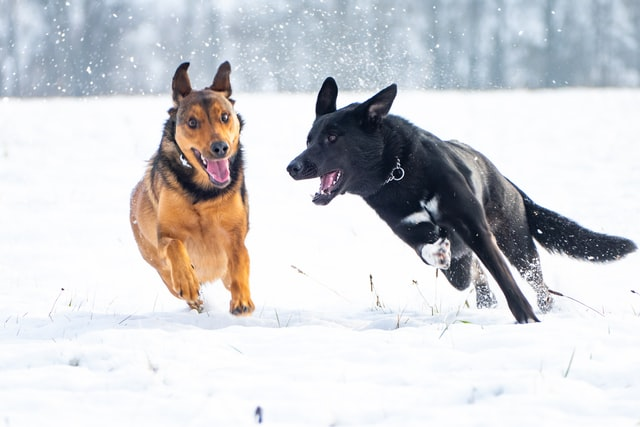

Hb6nGDgWztE.jpg


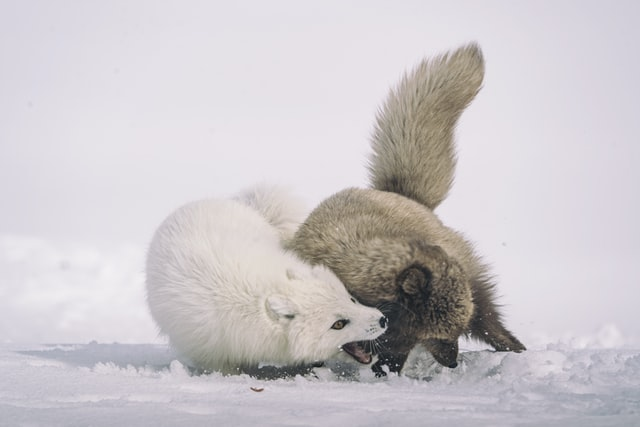

FwWTH1-O6xI.jpg


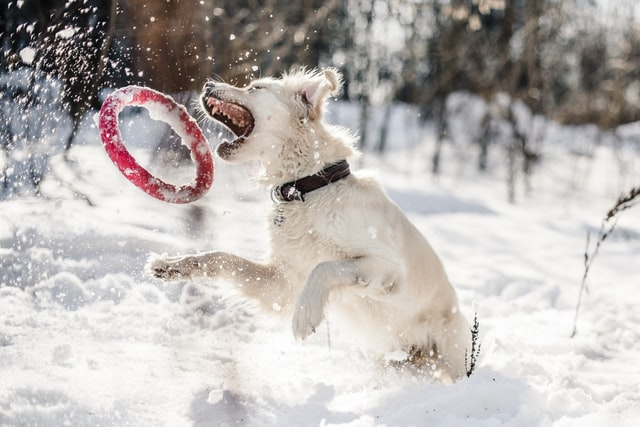

JAjrbewMbFQ.jpg


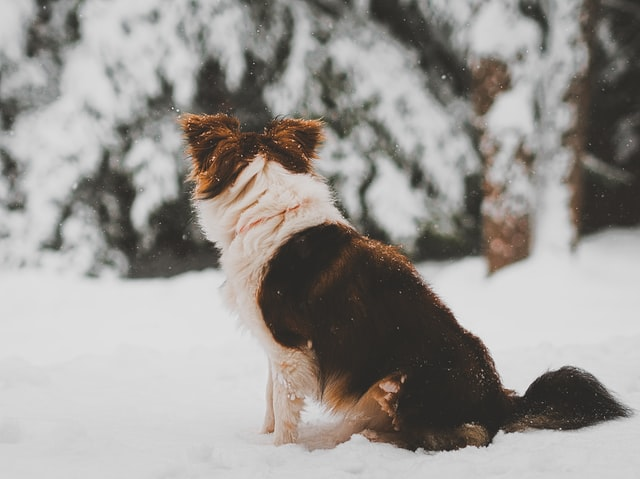

In [23]:
search("Two dogs playing in the snow")

Query:


'कुर्सी पर बिल्ली'

CgGDzMYdYw8.jpg


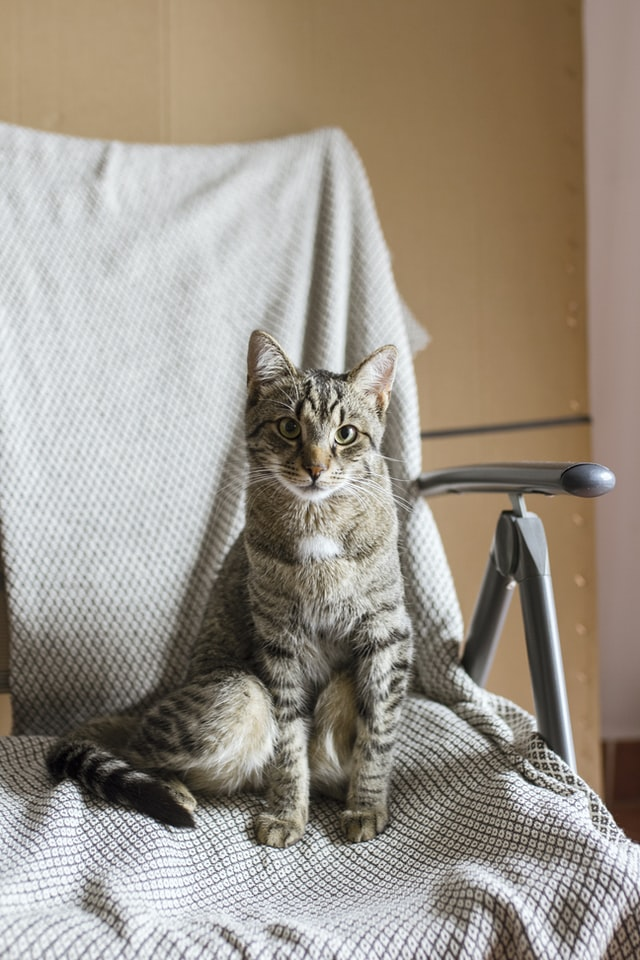

kjERLXaHjXc.jpg


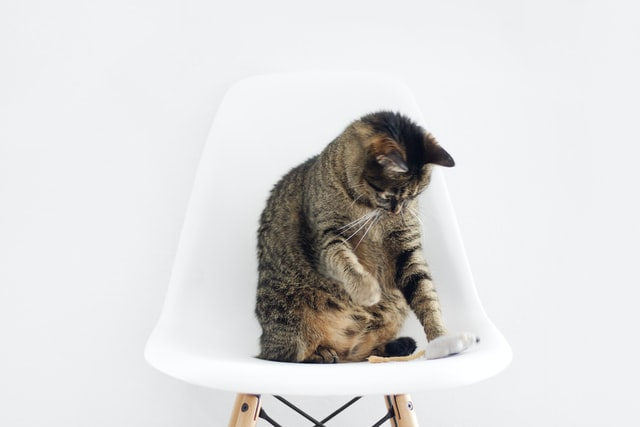

I-YJ-gaJNaw.jpg


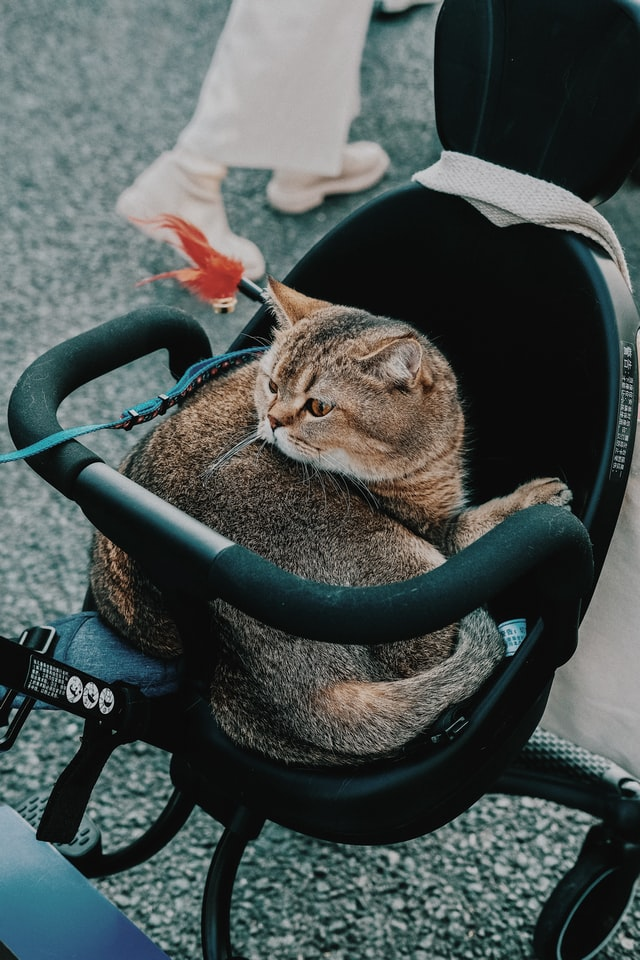

VWZ3OTlhqyE.jpg


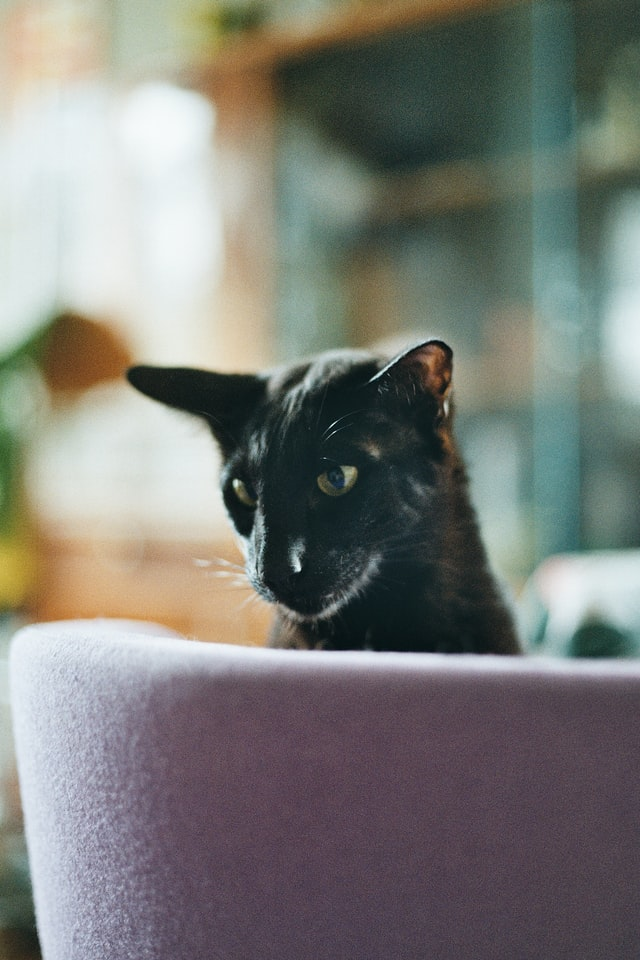

0ITYt-tkq4I.jpg


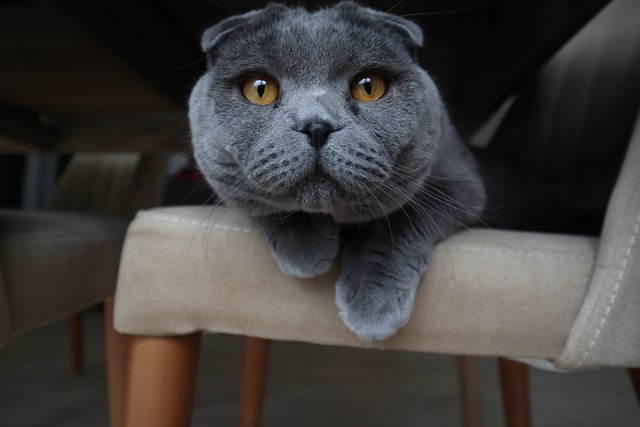

In [24]:
search("कुर्सी पर बिल्ली")

Query:


'पानी में हाथी'

2wWJ--XoTyg.jpg


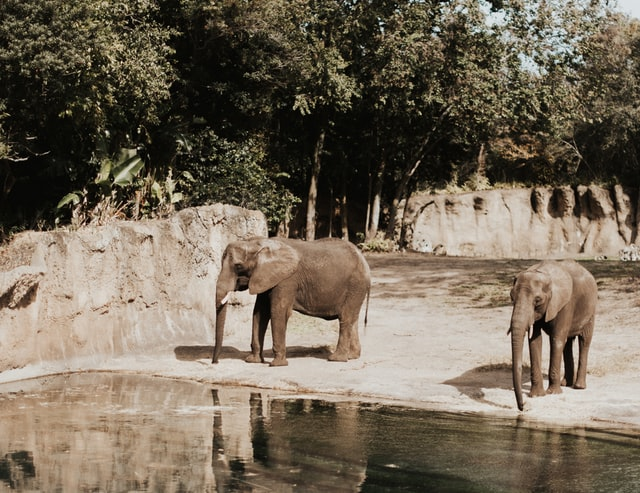

QHNb9b9aWWU.jpg


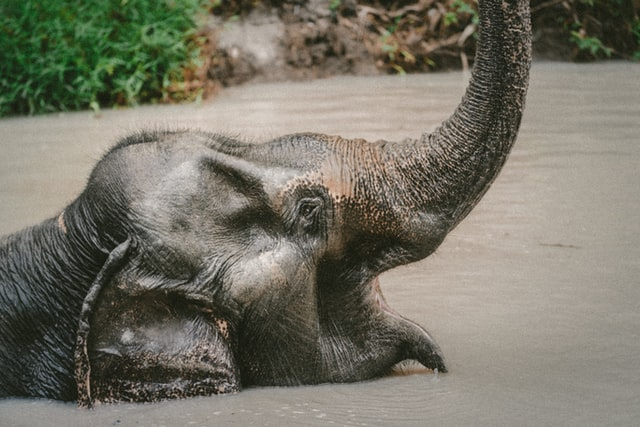

3uLnZ8hUBcw.jpg


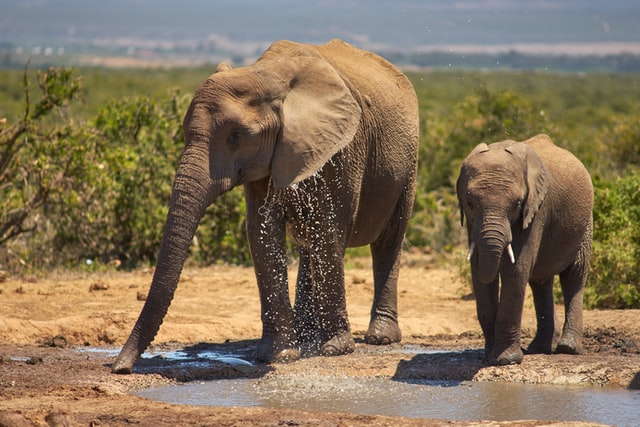

yTDiDDIJmso.jpg


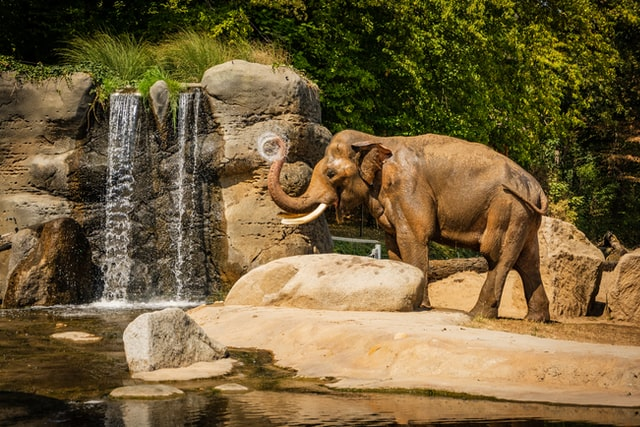

ny8DoR0IezI.jpg


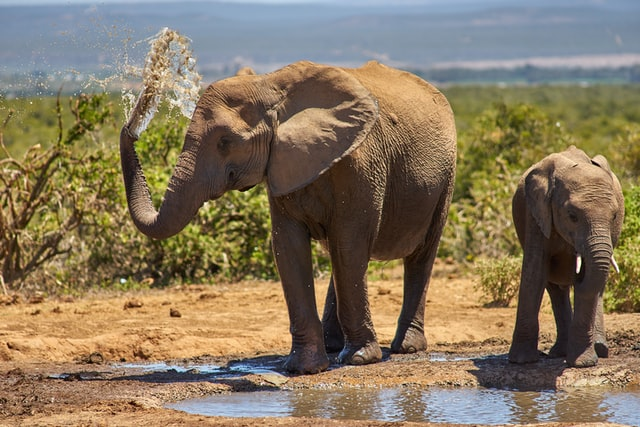

In [25]:
search("पानी में हाथी")

Query:


"fête de l'Inde"

RtlwmNGsPiE.jpg


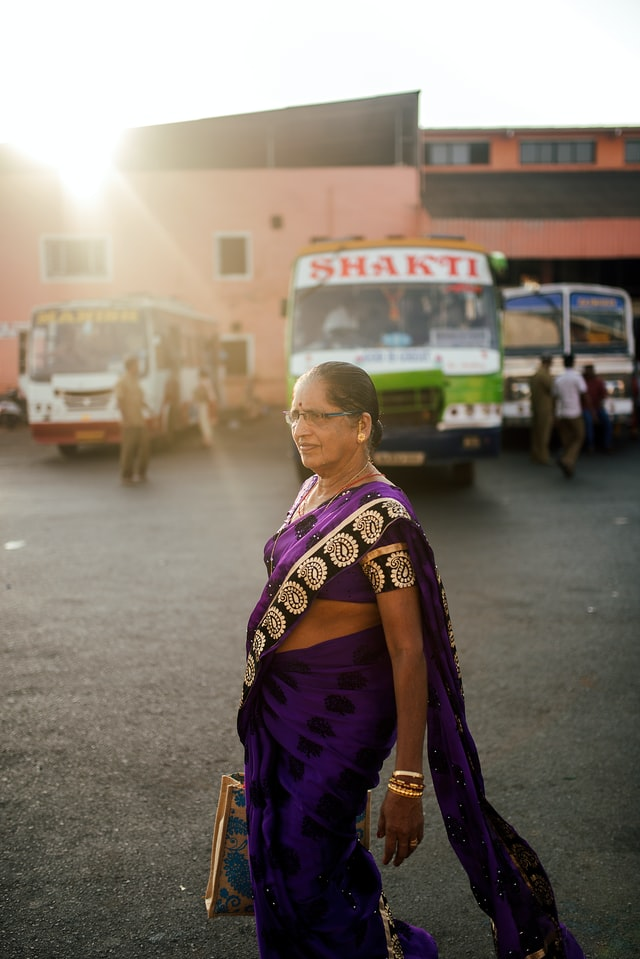

6ASyWY7CkpY.jpg


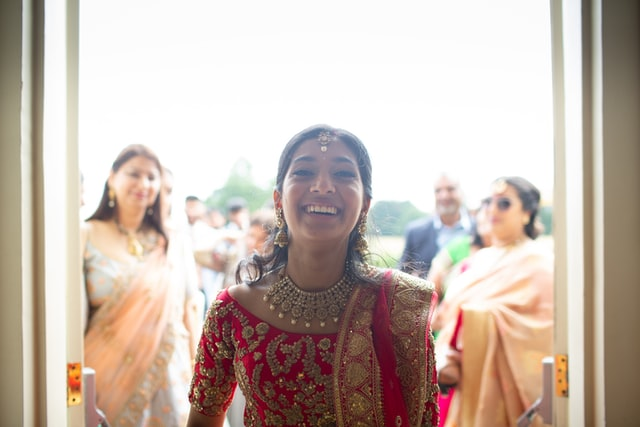

c4haFZYuRq4.jpg


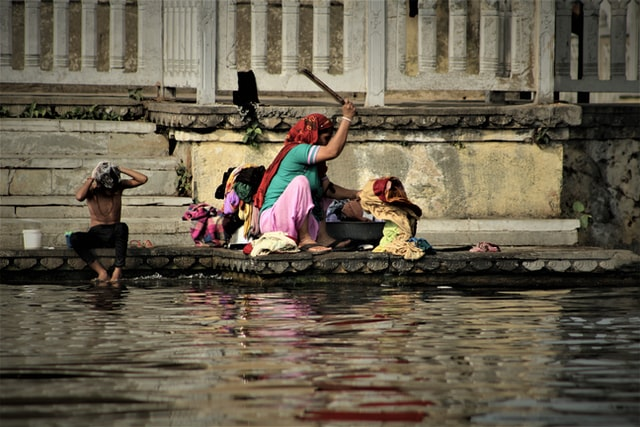

7BDP97v-tT8.jpg


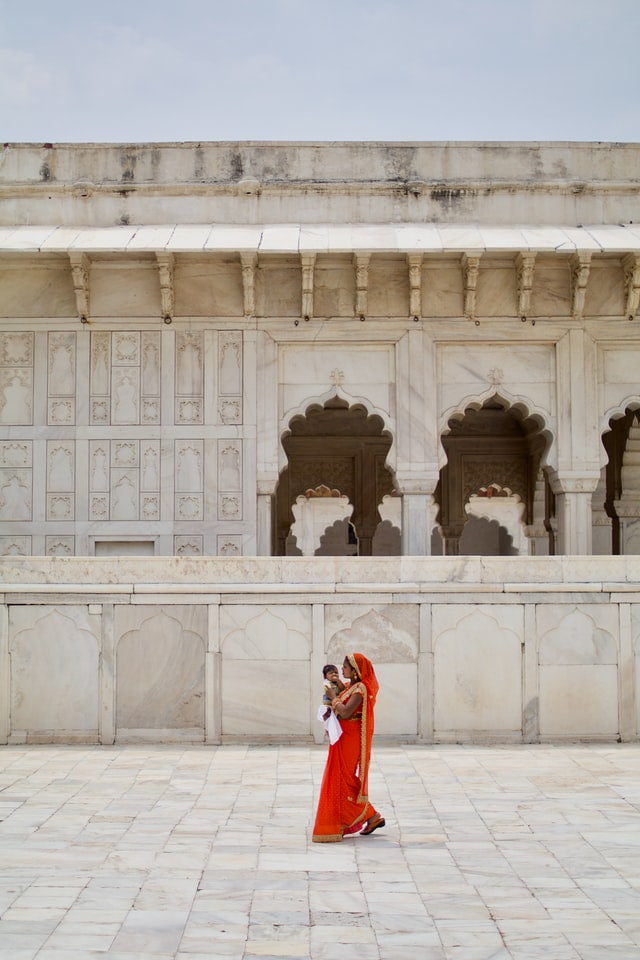

N2Wr1K9ie1E.jpg


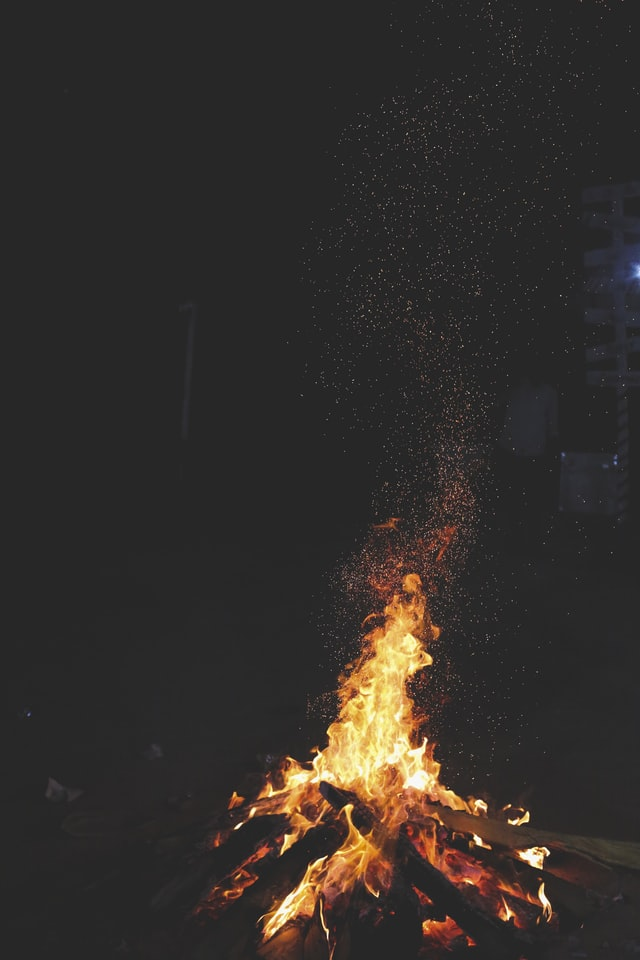

In [30]:
#French: Festival in India
search("fête de l'Inde")

Query:


'水のある山'

iCARCmC4loQ.jpg


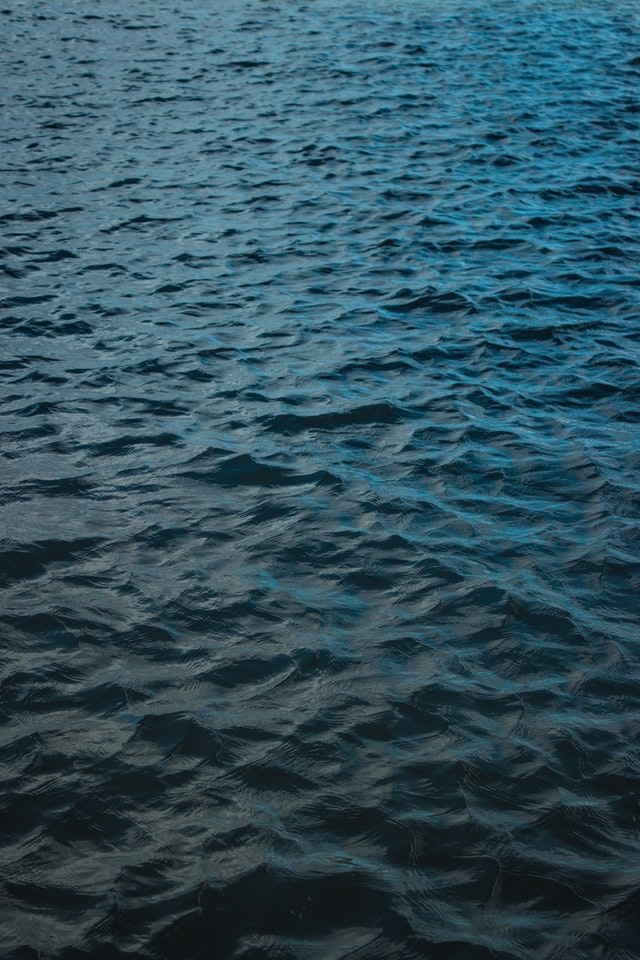

kub7wTHLsDI.jpg


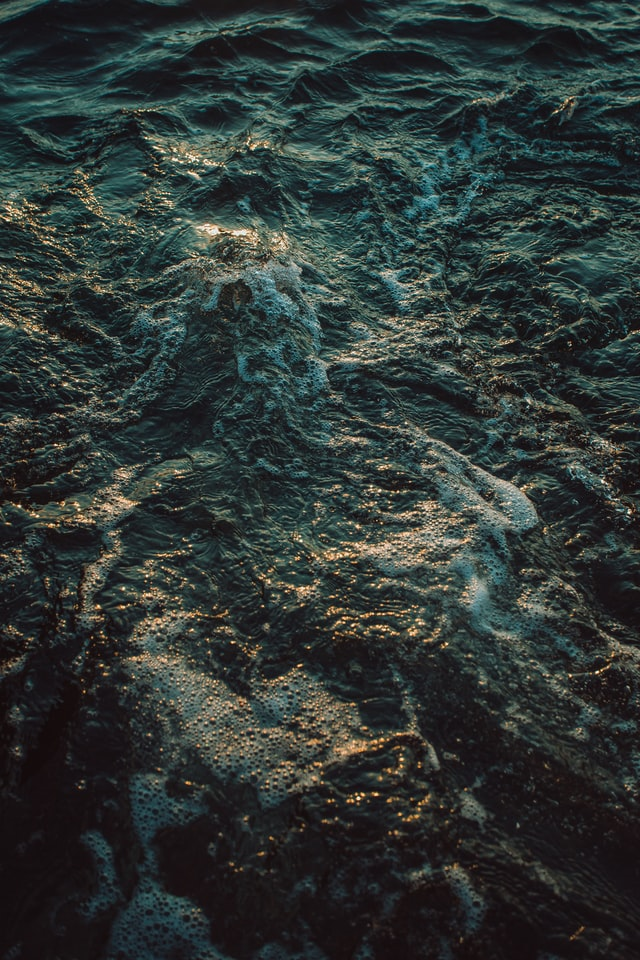

a-ZroHwP4pc.jpg


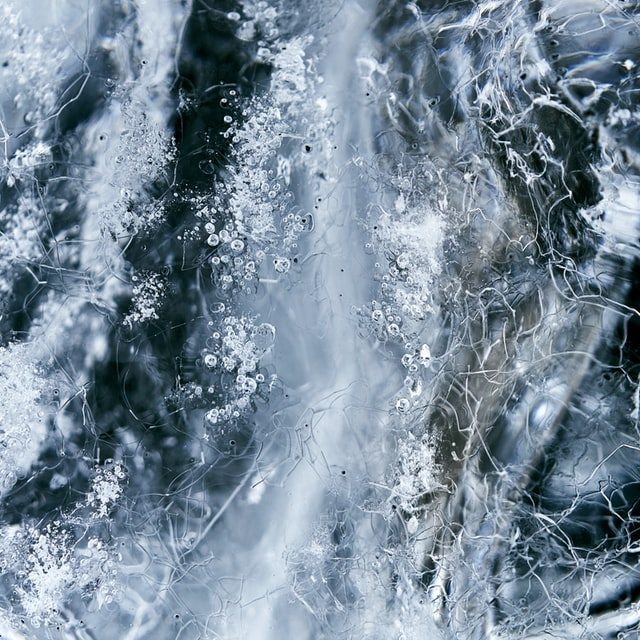

KMrEjF7jwEE.jpg


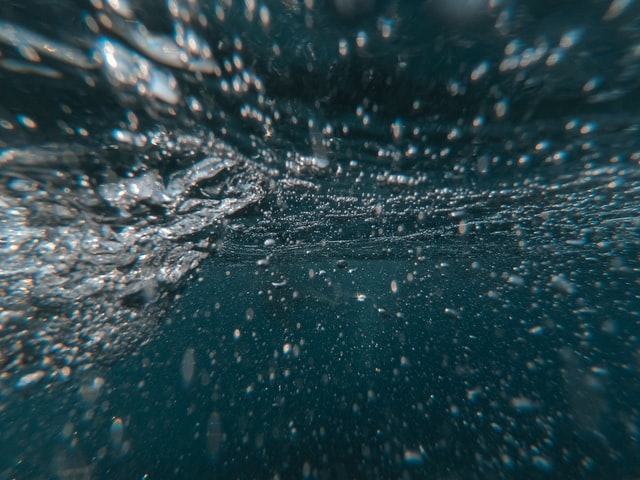

RnSSIvq4VKQ.jpg


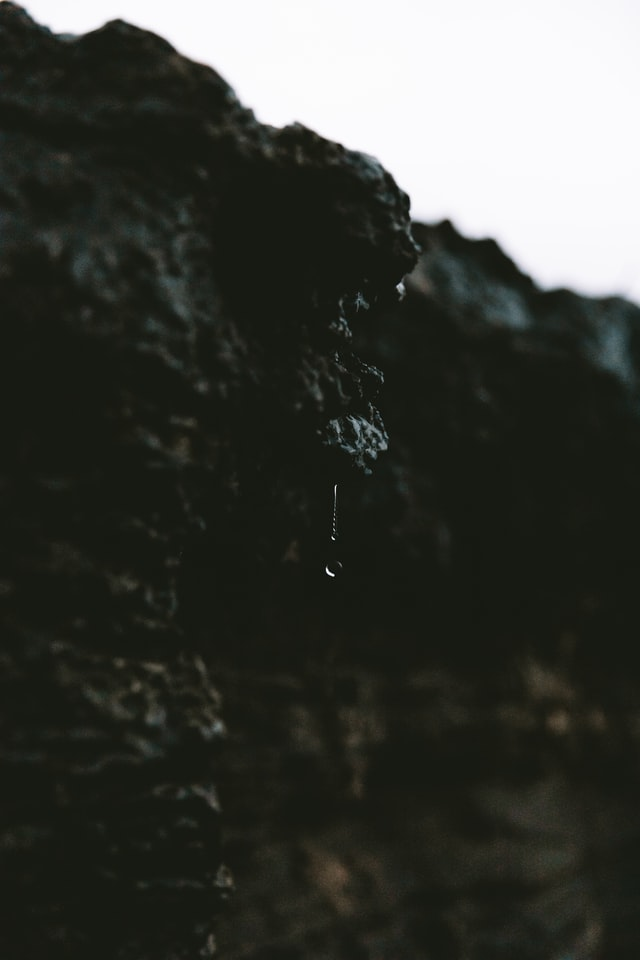

In [34]:
#Japanese: Mountains with water
search("水のある山")

Query:


'棕榈树的沙滩'

crIXKhUDpBI.jpg


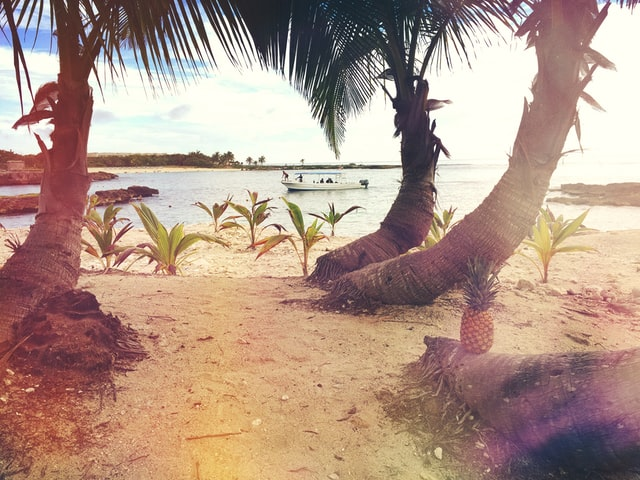

_6iV1AJZ53s.jpg


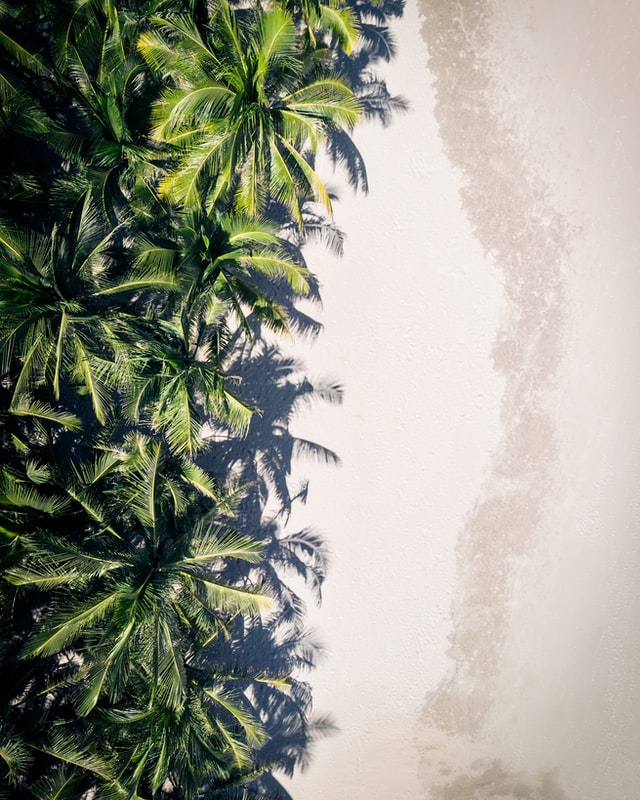

rv63du1a79E.jpg


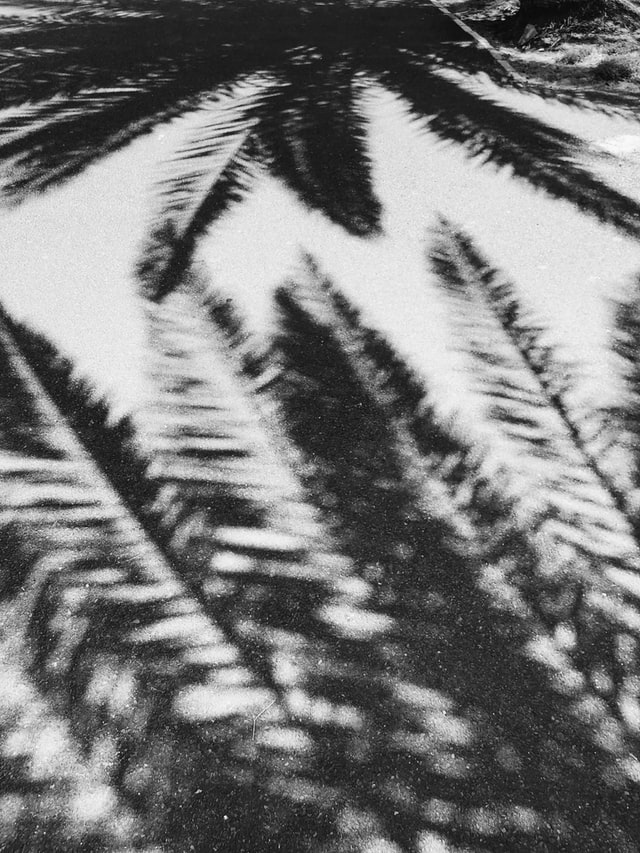

7rrgPPljqYU.jpg


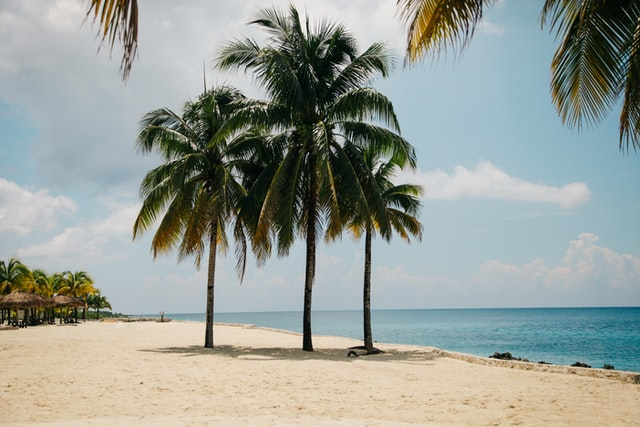

35onhFFHSWk.jpg


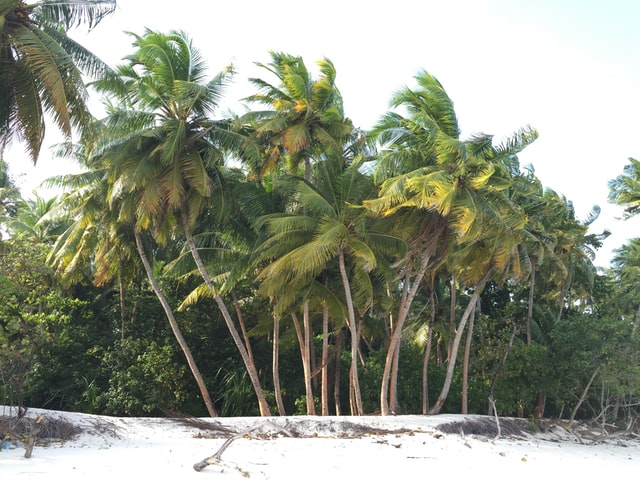

In [26]:
#Chinese: A beach with palm trees
search("棕榈树的沙滩")

Query:


'Закат на пляже'

JC5U3Eyiyr4.jpg


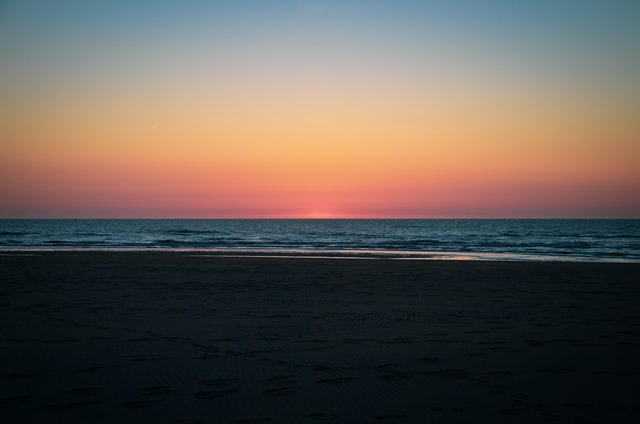

5z1QDcisnJ8.jpg


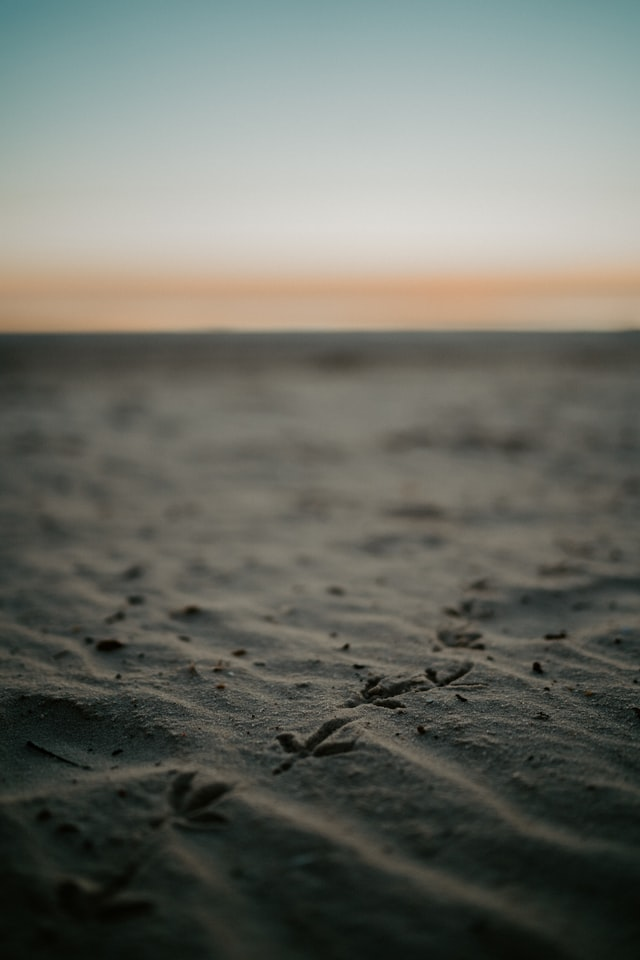

rdG4hRoyVR0.jpg


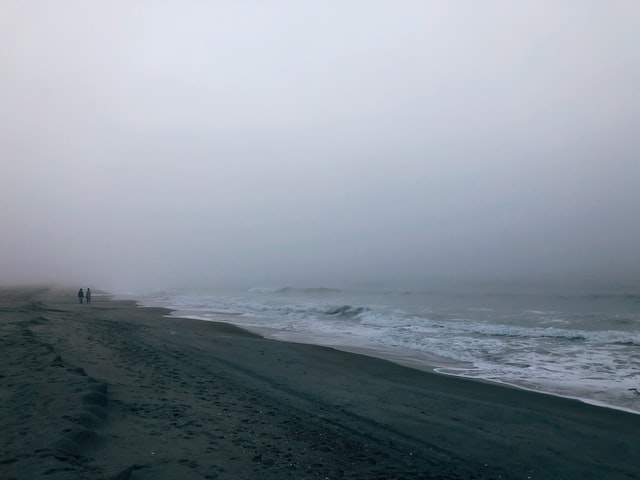

vlukOqxOA8o.jpg


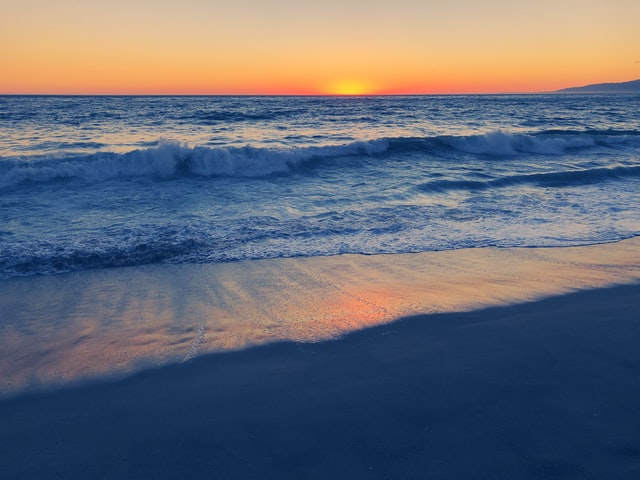

_qyPu6EJFf8.jpg


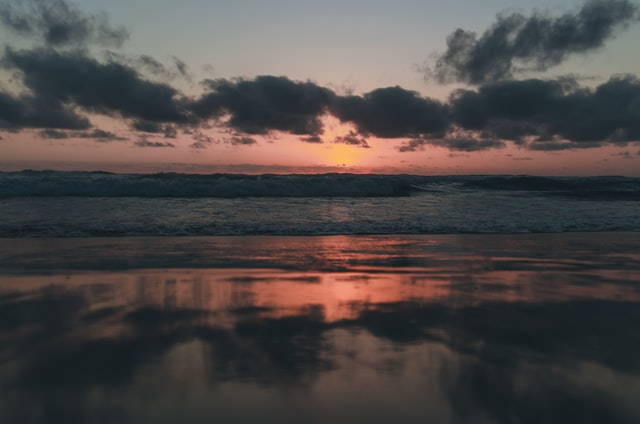

In [27]:
#Russian: A sunset on the beach
search("Закат на пляже")

Query:


'Parkta bir köpek'

ROJLfAbL1Ig.jpg


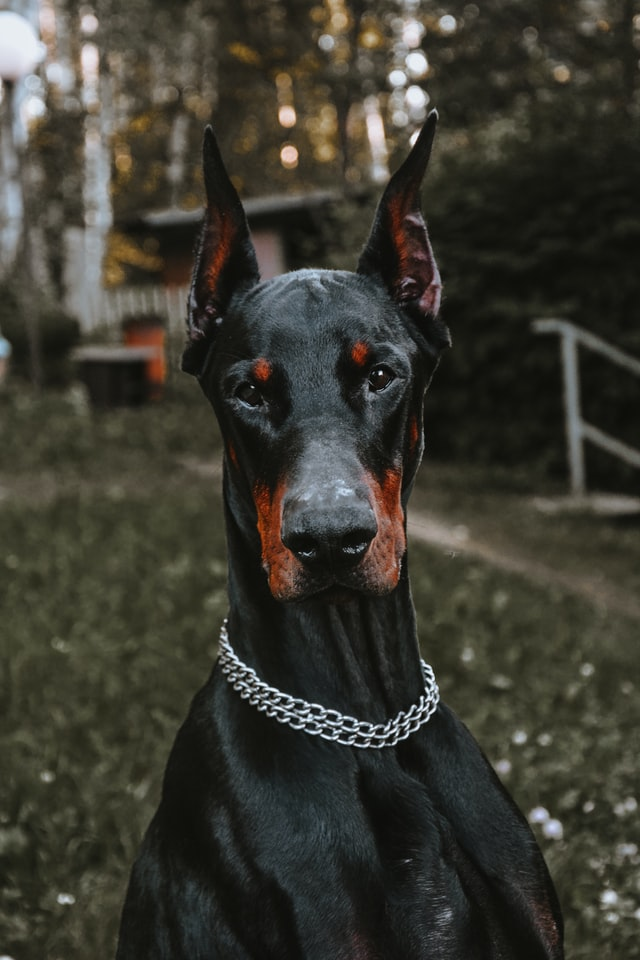

0O9A0F_d1qA.jpg


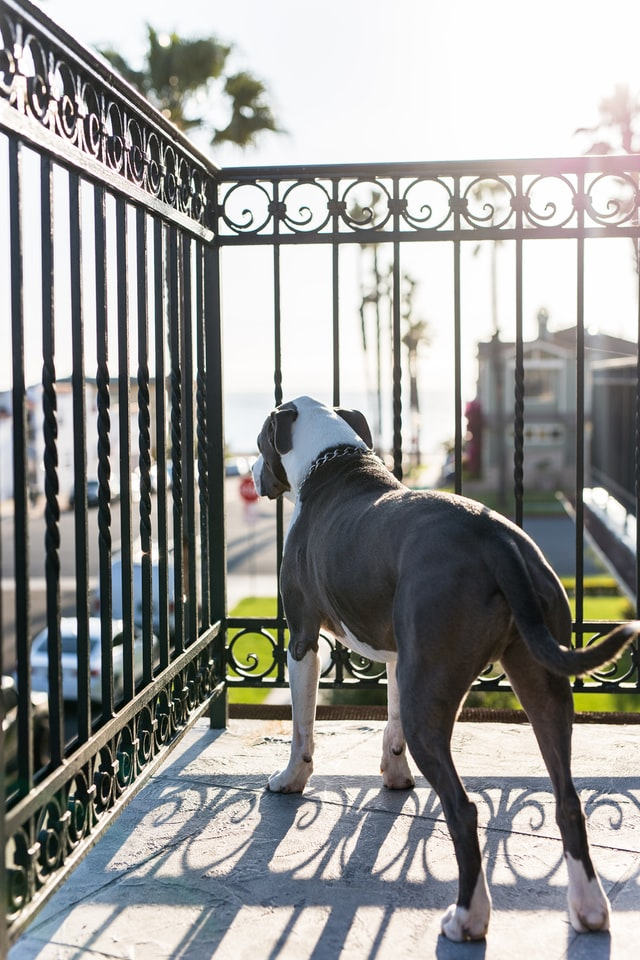

4mdsPUtN0P0.jpg


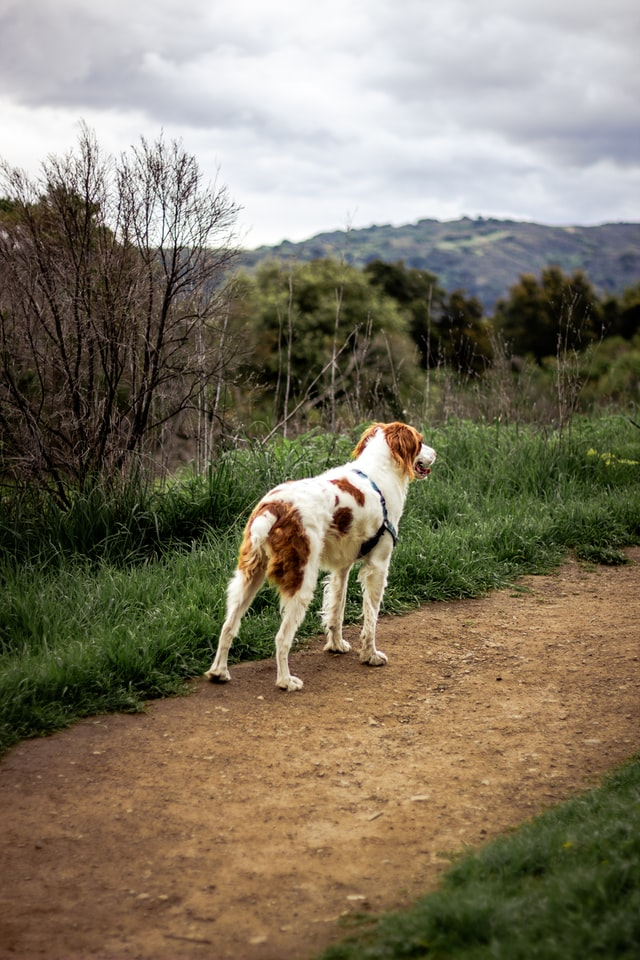

xuqp36-VuDM.jpg


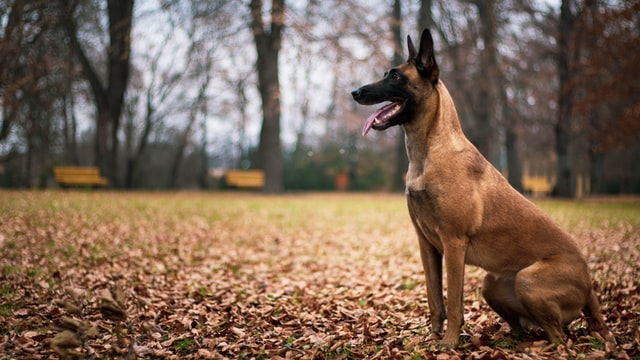

l6U3zdx3NdI.jpg


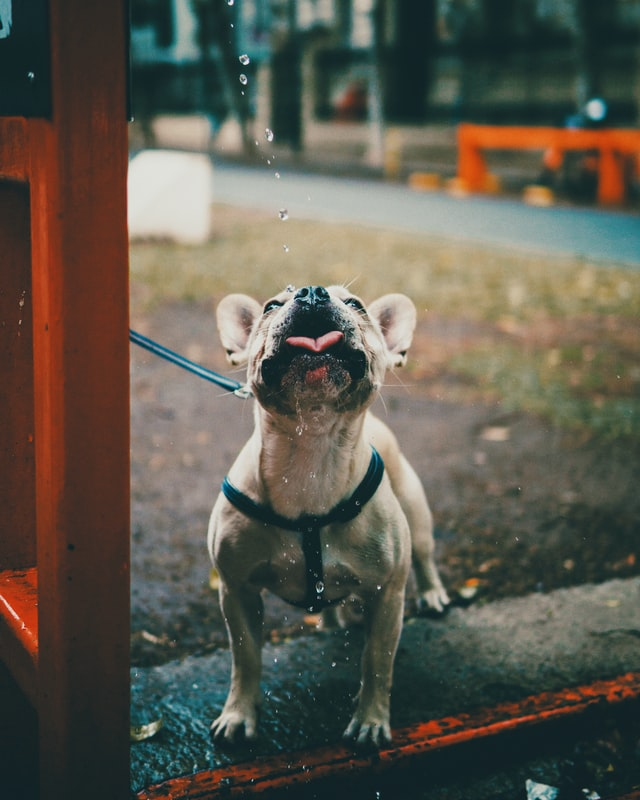

In [28]:
#Turkish: A dog in a park
search("Parkta bir köpek")

Query:


'夜のニューヨーク'

FGjR4IGwP7U.jpg


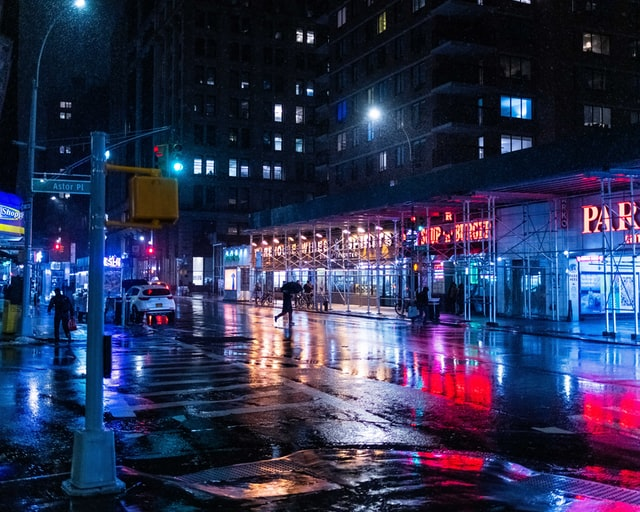

8nCMOFYyXF4.jpg


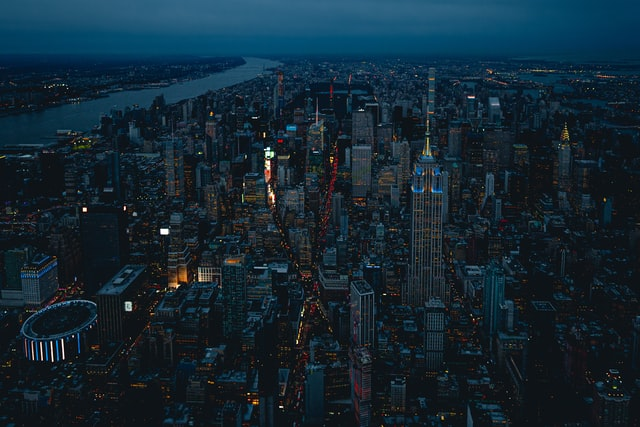

ZAOEjcpdMkc.jpg


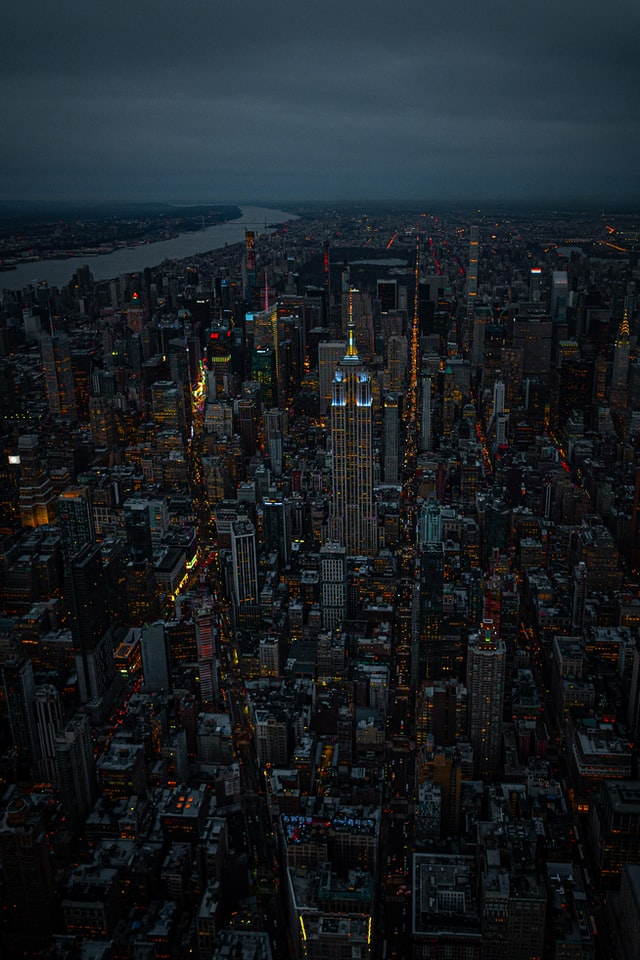

TzfAYmwwFP4.jpg


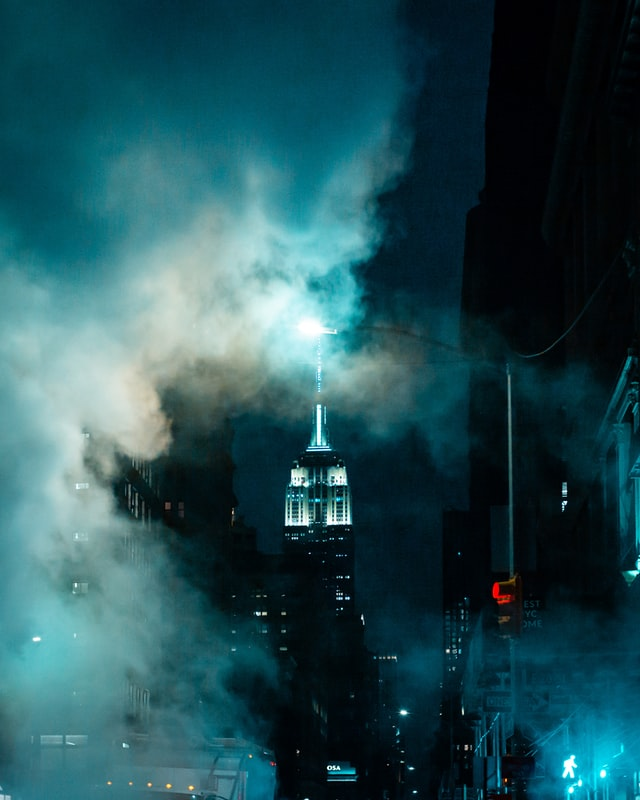

xpLNPVL3IJA.jpg


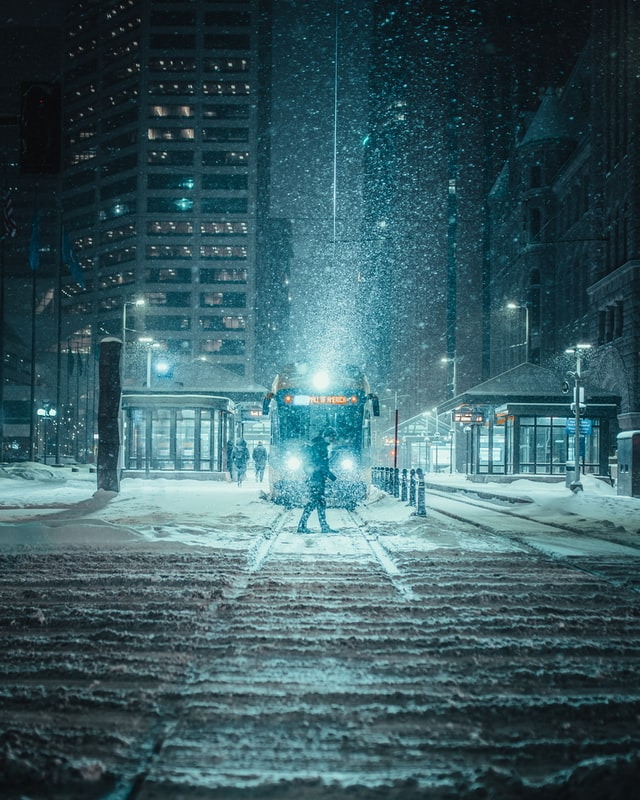

In [29]:
# Japanese: New York at night
search("夜のニューヨーク")